> we will try to build a sliced-score matching model on mixture of guassian models. 

we know that score matching is used to estimate the gradient of log density of a data. So once the model is trained for any given sample the network outputs gradient at that specific point. 

In order to estimate the actual value, we use langevin dynamics. It can produce samples from a probability density p(x) using only the score function. 

but there is a catch, when estimating gradients at low density points the model might not be performing well as it has not seen those locations previously at the time of training.


From the paper we have input data distribution as pdata = (1/5) N((−5,−5),I) + (4/5) N((5,5),I).

Lets see how to define this in pytorch.


In [331]:
import numpy as np 
import torch 
import torch.distributions as D
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
plt.style.use("bmh")
%matplotlib inline 


In [332]:
class BivariateGaussian(D.Distribution):
    def __init__(self, x0, y0, sigma=1.0):
        self.x0 = x0
        self.y0 = y0
        self.sigma = sigma
        self.mvn = D.MultivariateNormal(torch.tensor([x0, y0]), torch.eye(2) * sigma**2)
        
    def prob(self, x, y):
        return torch.exp(self.mvn.log_prob(torch.stack([x, y], dim=-1)))
    
    def prob_multiple(self, points):
        return torch.exp(self.mvn.log_prob(points))
    
    def sample(self, shape):
        return self.mvn.sample(shape)
    
    def mean(self):
        return torch.tensor([self.x0, self.y0])
    
    def laplacian(self, x, y):
        x_tensor = torch.tensor(x).requires_grad_(True)
        y_tensor = torch.tensor(y).requires_grad_(True) 
        log_prob = self.prob(x_tensor, y_tensor)
        log_prob.backward()
        return x_tensor.grad, y_tensor.grad
    
    def laplacian_multiple(self, points):
        X, Y = points.split(1, dim=-1)
        gradients = torch.zeros(X.shape[0], X.shape[1], 2)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                x_tensor = X[i][j].detach().clone().requires_grad_(True)
                y_tensor = Y[i][j].detach().clone().requires_grad_(True)
                vals = self.prob(x_tensor, y_tensor)
                vals.backward()
                gradients[i, j, :] = torch.stack([x_tensor.grad, y_tensor.grad], dim=-1)
                # Zero out gradients for next iteration
                x_tensor.grad.zero_()
                y_tensor.grad.zero_()
        return gradients
    

        
        

> Lets visualize a distribution first. 

In [333]:
x = torch.linspace(-3, 3, 20)
y = torch.linspace(-3, 3, 20)
X, Y = torch.meshgrid(x, y, indexing='ij')
XY = torch.stack([X, Y], dim=-1)

XY.shape

torch.Size([20, 20, 2])

In [334]:
model = BivariateGaussian(0, 0, sigma=1.0)
density = model.prob_multiple(XY)
density.shape

torch.Size([20, 20])

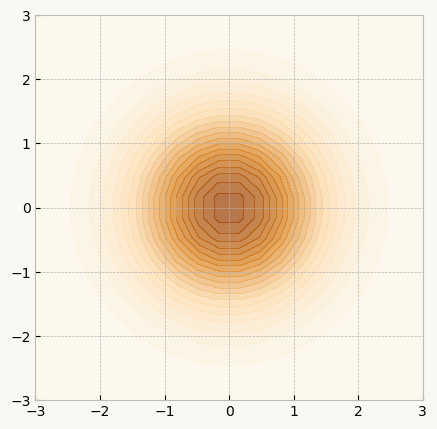

In [335]:
# Create a figure with two subplots
colors = [(1, 0.98, 0.94), (0.99, 0.85, 0.65), (0.85, 0.5, 0.1), (0.6, 0.24, 0)]
cmap_name = 'cream_orange'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

plt.figure(figsize=(5, 5), facecolor='#FAF8F4')
ax = plt.axes()
ax.set_facecolor('#FAF8F4')

# Plot the density as a color map
plt.contourf(X.numpy(), Y.numpy(), density.numpy(), cmap=cm, alpha=0.7, levels=20)
plt.show()

In [336]:
gradients = model.laplacian_multiple(XY)
#normalize the gradients
norm = np.sqrt(gradients[:, :, 0]**2 + gradients[:, :, 1]**2)
norm[norm == 0] = 1  # Avoid division by zero
gradients[:, :, 0] = gradients[:, :, 0] / norm
gradients[:, :, 1] = gradients[:, :, 1] / norm
gradients.shape

torch.Size([20, 20, 2])

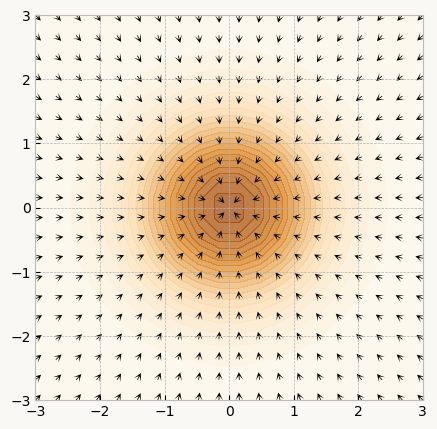

In [337]:
# Create a figure with two subplots
colors = [(1, 0.98, 0.94), (0.99, 0.85, 0.65), (0.85, 0.5, 0.1), (0.6, 0.24, 0)]
cmap_name = 'cream_orange'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

plt.figure(figsize=(5, 5), facecolor='#FAF8F4')
ax = plt.axes()
ax.set_facecolor('#FAF8F4')

# Plot the density as a color map
plt.contourf(X.detach().numpy(), Y.detach().numpy(), density.detach().numpy(), cmap=cm, alpha=0.7, levels=20)
plt.quiver(X.detach().numpy(), Y.detach().numpy(), gradients[:, :, 0].detach().numpy(), gradients[:, :, 1].detach().numpy(), 
           color='black', 
           scale=50,  # Adjust this value to change arrow length
           width=0.003,  # Arrow width
           headwidth=10,  # Head width relative to shaft width
           headlength=10,  # Head length relative to shaft width
           headaxislength=4.5)  # Head length at shaft intersection


plt.show()

In [338]:
## Now we have two distributions and want 

class BivariateGaussian2Dist(D.Distribution):
    def __init__(self, x0, y0, x1, y1, sigma1=1.0, sigma2=1.0, w1=1/5, w2=4/5):
        self.x0 = x0
        self.y0 = y0
        self.x1 = x1
        self.y1 = y1
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.w1 = w1
        self.w2 = w2
        self.mvn1 = D.MultivariateNormal(torch.tensor([x0, y0]), torch.eye(2) * sigma1**2)
        self.mvn2 = D.MultivariateNormal(torch.tensor([x1, y1]), torch.eye(2) * sigma2**2)
        
    def prob(self, x, y):
        return self.w1*torch.exp(self.mvn1.log_prob(torch.stack([x, y], dim=-1))) + self.w2*torch.exp(self.mvn2.log_prob(torch.stack([x, y], dim=-1)))
    
    
    def prob_multiple(self, points):
        return self.w1*torch.exp(self.mvn1.log_prob(points)) + self.w2*torch.exp(self.mvn2.log_prob(points))
    
    def sample(self, shape):
        return self.w1*self.mvn1.sample(shape) + self.w2*self.mvn2.sample(shape)
    
    def mean(self):
        return self.w1*torch.tensor([self.x0, self.y0]) + self.w2*torch.tensor([self.x1, self.y1])
    
    def laplacian_multiple(self, points):
        X, Y = points.split(1, dim=-1)
        gradients = torch.zeros(X.shape[0], X.shape[1], 2)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                x_tensor = X[i][j].detach().clone().requires_grad_(True)
                y_tensor = Y[i][j].detach().clone().requires_grad_(True)
                vals = self.prob(x_tensor, y_tensor)
                vals.backward()
                gradients[i, j, :] = torch.stack([x_tensor.grad, y_tensor.grad], dim=-1)
                # Zero out gradients for next iteration
                x_tensor.grad.zero_()
                y_tensor.grad.zero_()
        return gradients 
        



In [339]:
# pdata = 1/5 N((−5,−5),I) + 4/5 N((5,5),I)
model = BivariateGaussian2Dist(-5, -5, 5, 5, sigma1=1.0, sigma2=1.0, w1=1/5, w2=4/5)
model.x0, model.y0, model.x1, model.y1

(-5, -5, 5, 5)

In [340]:
x = torch.linspace(-7, 7, 20)
y = torch.linspace(-7, 7, 20)
X, Y = torch.meshgrid(x, y, indexing='ij')
XY = torch.stack([X, Y], dim=-1)

XY.shape

torch.Size([20, 20, 2])

In [341]:
density = model.prob_multiple(XY)
density.shape

torch.Size([20, 20])

In [342]:
density[10, 10]

tensor(6.1475e-11)

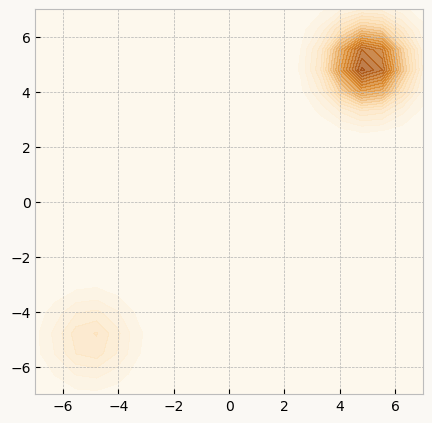

In [343]:
# Create a figure with two subplots
colors = [(1, 0.98, 0.94), (0.99, 0.85, 0.65), (0.85, 0.5, 0.1), (0.6, 0.24, 0)]
cmap_name = 'cream_orange'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

plt.figure(figsize=(5, 5), facecolor='#FAF8F4')
ax = plt.axes()
ax.set_facecolor('#FAF8F4')

# Plot the density as a color map
plt.contourf(X.numpy(), Y.numpy(), density.numpy(), cmap=cm, alpha=0.7, levels=20)
plt.show()

In [344]:
gradients = model.laplacian_multiple(XY)
norm = np.sqrt(gradients[:, :, 0]**2 + gradients[:, :, 1]**2)
norm[norm == 0] = 1  # Avoid division by zero
gradients[:, :, 0] = gradients[:, :, 0] / norm
gradients[:, :, 1] = gradients[:, :, 1] / norm
gradients.shape

torch.Size([20, 20, 2])

In [345]:
gradients[10, 10, :]

tensor([0.7071, 0.7071])

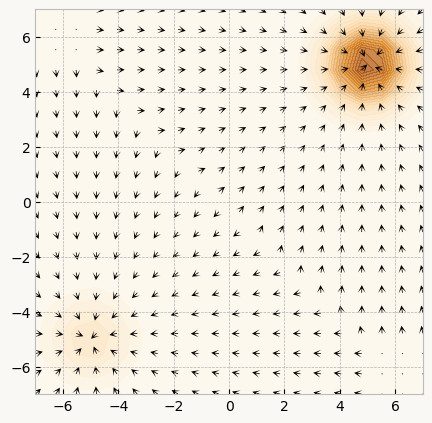

In [346]:
# Create a figure with two subplots
colors = [(1, 0.98, 0.94), (0.99, 0.85, 0.65), (0.85, 0.5, 0.1), (0.6, 0.24, 0)]
cmap_name = 'cream_orange'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

plt.figure(figsize=(5, 5), facecolor='#FAF8F4')
ax = plt.axes()
ax.set_facecolor('#FAF8F4')

# Plot the density as a color map
plt.contourf(X.detach().numpy(), Y.detach().numpy(), density.detach().numpy(), cmap=cm, alpha=0.7, levels=20)
plt.quiver(X.detach().numpy(), Y.detach().numpy(), gradients[:, :, 0].detach().numpy(), gradients[:, :, 1].detach().numpy(), 
           color='black', 
           scale=50,  # Adjust this value to change arrow length
           width=0.003,  # Arrow width
           headwidth=10,  # Head width relative to shaft width
           headlength=10,  # Head length relative to shaft width
           headaxislength=4.5)  # Head length at shaft intersection


plt.show()

> our goal is to estimate similar gradients using a neural network. 

## Langevin dynamics

here we will see how to sample data from this distribution using langevin dynamics. we use the following formula to sample this. 

$$
x_{t+1} = x_t + \varepsilon \nabla \log p(x_t) + \sqrt{2\varepsilon} z_t
$$

we will randomly take 500 samples and use 1000 steps. We will consider our initial point to be sampled from N(0, I). Ideally we need 1/5 samples to go towards (-5, -5) and 4/5th samples to go towards (5, 5).



In [362]:
n_samples = 500 
n_steps = 1000
step_size = 0.01 
initial_points = torch.randn(n_samples, 2)
initial_points.shape

torch.Size([500, 2])

Now calculating gradient for each sample (500) for n_steps (1000) is time taking  and computationally infesible. so we calculate for all the 500 samples at a time using summation. when taking derivative wrt to each input in summation other values will be zero. Below is an example from claude.

```
∇(sum of log probs) = sum of ∇(log probs)
Let's say we have two independent samples x₁ and x₂, and we want to compute gradients of their log probabilities. For simplicity, let's use a univariate Gaussian distribution with mean μ = 0 and variance σ² = 1.

The log probability for a univariate Gaussian is:
log p(x) = -0.5 log(2π) - 0.5 x²

For our two samples:
log p(x₁) = -0.5 log(2π) - 0.5 x₁²
log p(x₂) = -0.5 log(2π) - 0.5 x₂²

Step 1: Calculate the sum of log probabilities
sum of log probs = log p(x₁) + log p(x₂) = -log(2π) - 0.5(x₁² + x₂²)

Step 2: Calculate the gradient of the sum with respect to each sample
∇ₓ₁(sum of log probs) = -x₁
∇ₓ₂(sum of log probs) = -x₂
So ∇(sum of log probs) = [-x₁, -x₂]

Step 3: Calculate individual gradients and then sum them
∇ₓ₁(log p(x₁)) = -x₁
∇ₓ₂(log p(x₂)) = -x₂
sum of ∇(log probs) = [-x₁, -x₂]

As you can see, ∇(sum of log probs) = sum of ∇(log probs) = [-x₁, -x₂]
```

In [363]:
# Set up storage for samples
current_samples = initial_points.clone().requires_grad_(True)

# Set up storage for trajectory (optional, for visualization)
trajectory = [current_samples.clone().detach()]

# Langevin dynamics loop
for step in range(n_steps):
    # Compute probability and gradients
    log_prob = torch.log(model.prob_multiple(current_samples))
    
    # Get gradients of log probability with respect to samples
    gradients = torch.autograd.grad(log_prob.sum(), current_samples)[0]
    
    # Langevin update: x_new = x_old + step_size * gradient + sqrt(2*step_size) * noise
    noise = torch.randn_like(current_samples)
    with torch.no_grad():
        current_samples.add_(step_size * gradients + torch.sqrt(torch.tensor(2.0 * step_size)) * noise)
    
    # Reset gradients for next iteration
    current_samples.requires_grad_(True)
    
    # Store samples (optional, for visualization)
    if step % 100 == 0:
        trajectory.append(current_samples.clone().detach())


In [364]:
samples = current_samples.detach().numpy()
samples.shape

(500, 2)

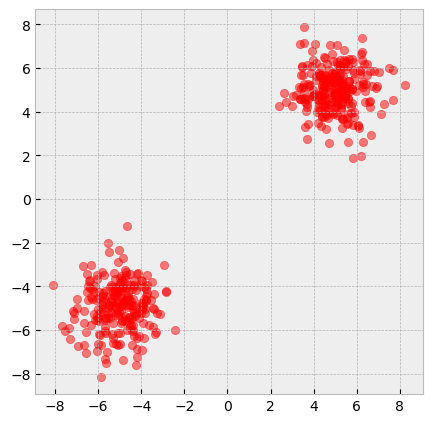

In [365]:
plt.figure(figsize=(5, 5))
plt.scatter(samples[:, 0], samples[:, 1], 
                color='red', alpha=0.5, label='Langevin Samples')
plt.show()

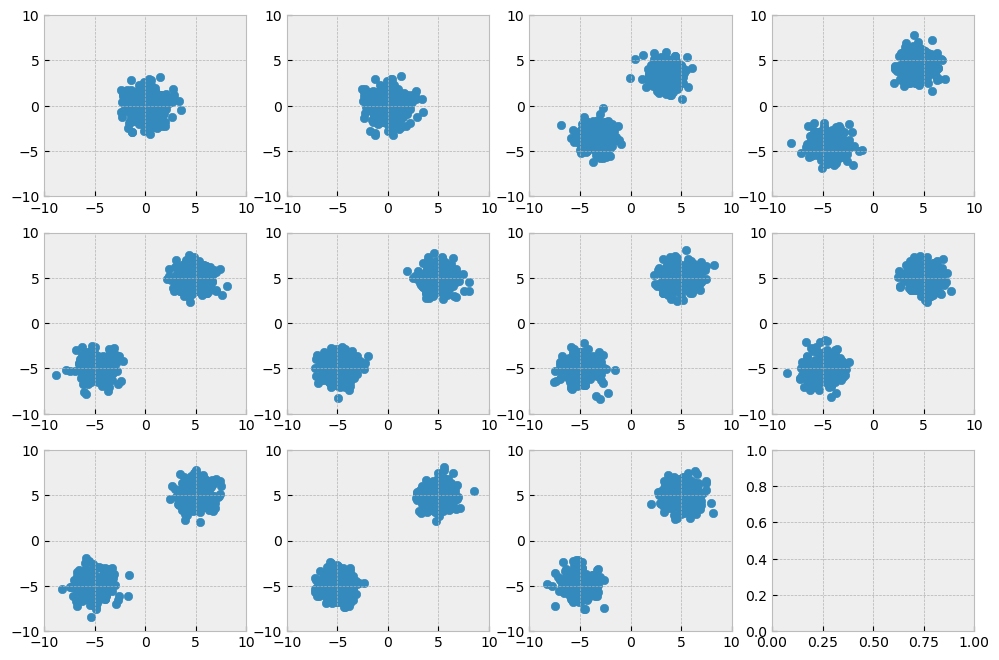

In [377]:
## visualzing the trajectories 

fig, ax = plt.subplots(figsize=(3*4, 4*2), nrows=3, ncols=4)
for i in range(len(trajectory)):
    ax.flat[i].scatter(trajectory[i][:, 0], trajectory[i][:, 1])
    #set x limits and y limits 
    ax.flat[i].set_xlim([-10, 10])
    ax.flat[i].set_ylim([-10, 10])
plt.show()

In [366]:
samples[(samples[:, 0] <0 ) & (samples[:, 0]<0)].shape, samples[(samples[:, 0] >0 ) & (samples[:, 0]>0)].shape

((239, 2), (261, 2))

> In the run which I did, the data has two modes with equal number of samples at each mode. However the original weightage given to each of these modes is not the same. 

## Annealed langevin dynamics.

